In [68]:
!date

Wed Apr 27 09:15:48 MDT 2016


In [69]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import spacepy.toolbox as tb
import spacepy.plot as spp
from pprint import pprint

import pymc
%matplotlib inline

I am looking to work out how to handle Bayesian estimation in a rate counting system. 
### Model
1. Foreground data we want is Binomial with trials 100 and probability 0.5, the number of samples will be changed to see how that impacts the results
2. Background is taken to be Binomial with trails 1e3 and probability 0.01, number of samples will be the same as foreground
3. Add a nuisiance parameter, $\alpha$, to represent systematic uncertantity. 
  1. Is this U[0,100] or just a number?

In [70]:
samples = tb.logspace(1, 10000, 10)

[    1.             2.15443469     4.64158883    10.            21.5443469
    46.41588834   100.           215.443469     464.15888336  1000.        ]


/Users/blarsen/miniconda3/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


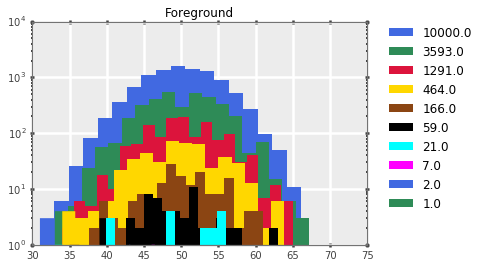

In [71]:
fore = [np.random.binomial(100, 0.50, size=v) for v in samples]
print(tb.logspace(1, 1000, 10))
for v in fore[::-1]:
    h = np.histogram(v, 20)
    plt.hist(v, 20, label='{0}'.format(np.floor(len(v))))
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Foreground')

/Users/blarsen/miniconda3/envs/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


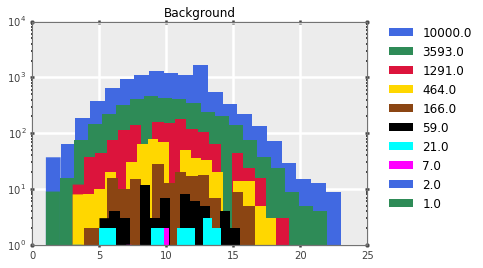

In [72]:
back = [np.random.binomial(1e3, 0.01, size=v) for v in samples]
for v in back[::-1]:
    h = np.histogram(v, 20)
    plt.hist(v, 20, label='{0}'.format(np.floor(len(v))))
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Background')

In [73]:
alpha = 10.0 # make the same as the cetner of the Background, no real reason

In [74]:
syn = []
for i in range(len(fore)):
    syn.append(fore[i] + back[i] + alpha)
syn[5]

array([ 73.,  69.,  73.,  64.,  76.,  79.,  72.,  77.,  73.,  63.,  69.,
        73.,  69.,  67.,  72.,  71.,  62.,  70.,  66.,  65.,  69.,  76.,
        72.,  77.,  69.,  73.,  85.,  75.,  69.,  69.,  74.,  70.,  63.,
        75.,  65.,  69.,  68.,  56.,  71.,  70.,  61.,  76.,  72.,  80.,
        64.,  66.,  77.,  70.,  69.,  72.,  78.,  69.,  76.,  71.,  67.,
        65.,  64.,  77.,  61.,  73.,  75.,  74.,  80.,  68.,  70.,  68.,
        68.,  78.,  51.,  80.,  58.,  75.,  72.,  76.,  66.,  67.,  68.,
        77.,  79.,  79.,  69.,  71.,  75.,  68.,  72.,  61.,  71.,  79.,
        66.,  72.,  68.,  70.,  67.,  73.,  82.,  78.,  82.,  60.,  69.,
        60.,  71.,  73.,  70.,  66.,  76.,  58.,  77.,  72.,  74.,  61.,
        72.,  78.,  68.,  58.,  68.,  73.,  66.,  69.,  69.,  85.,  69.,
        64.,  71.,  77.,  64.,  82.,  80.,  71.,  68.,  84.,  76.,  81.,
        74.,  66.,  61.,  68.,  74.,  66.,  62.,  71.,  72.,  63.,  70.,
        73.,  62.,  71.,  73.,  69.,  79.,  69.,  5

Now it is time to create the Bayesian model that will estimate these parameters.

Matching the above we will have:
* ForeB = Bi()
* BackB = Bi()
* $\alpha$B = Number

In [83]:
foreN = pymc.Uniform('foreN', lower=0, upper=1e6)
backN = pymc.Uniform('backN', lower=0, upper=1e6) # , observed=True, value=[1e3], plot=True)

foreP = pymc.Uniform('foreP', lower=0, upper=1) # , observed=True, value=[0.5, 0.4, 0.55])
backP = pymc.Uniform('backP', lower=0, upper=1)




foreB  = pymc.Binomial('fore', n=foreN, p=foreP, observed=True, value=fore[-1])
backB  = pymc.Binomial('back', n=backN, p=backP, observed=True, value=back[-1])
# @pymc.stochastic
# def alphaB(value=100):
#     return value


M = pymc.MCMC([foreB, backB, foreN, backN, foreP, backP])

 [-----------------100%-----------------] 20000 of 20000 complete in 122.7 secPlotting backN
Plotting foreP
Plotting backP
Plotting foreN


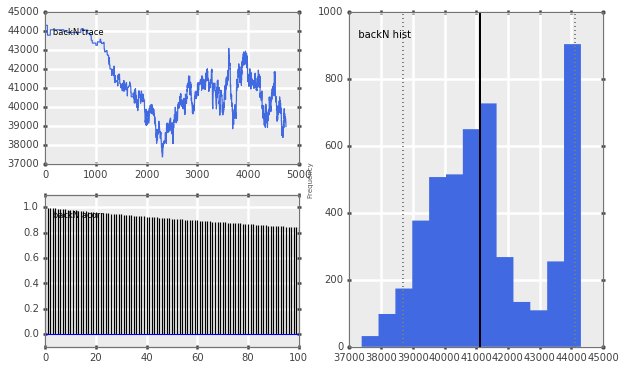

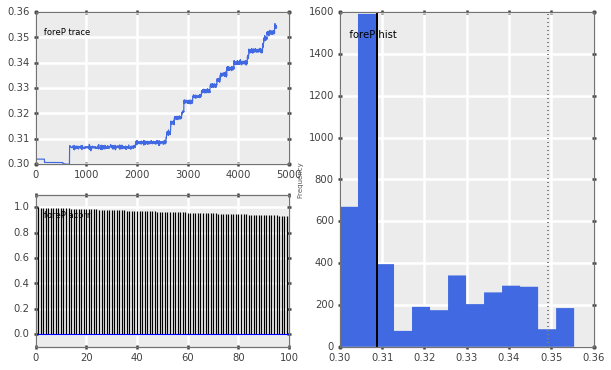

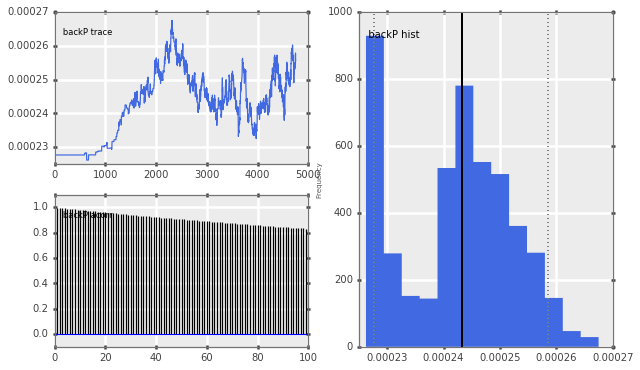

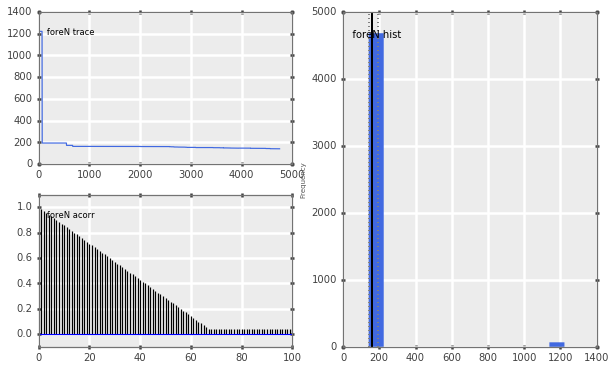

In [84]:
M.sample(iter=2e4, burn=1e3, thin=4)
pymc.Matplot.plot(M)

In [85]:
pprint(M.stats())

{'backN': {'95% HPD interval': array([ 38675.07867253,  44120.99001134]),
           'mc error': 169.8063668974734,
           'mean': 41359.833998077826,
           'n': 4750,
           'quantiles': {2.5: 38414.825299676697,
                         25: 40040.854248913347,
                         50: 41125.785477384037,
                         75: 42941.353712216478,
                         97.5: 44064.862850958554},
           'standard deviation': 1722.5381905012766},
 'backP': {'95% HPD interval': array([ 0.00022772,  0.00025848]),
           'mc error': 9.7848250218625056e-07,
           'mean': 0.00024231073504385689,
           'n': 4750,
           'quantiles': {2.5: 0.00022772183670535101,
                         25: 0.00023224312969934944,
                         50: 0.00024325660274242069,
                         75: 0.0002496797298919115,
                         97.5: 0.00026016282789448981},
           'standard deviation': 9.9278713992695398e-06},
 'foreN': {'95% 

/Users/blarsen/miniconda3/envs/python3/lib/python3.4/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)
